# Regression

In this notebook, it is shown that the library can also be used for regression on top of classification. The main difference between models for classification and regression is the loss function and the last layer of the network. In the case of regression, the loss is defined as the ```MeanSquaredErrorLoss```, the performance metrics is defined as the ```MeanSquaredErrorMetrics```, and the ```Model```'s last layer has ```LinearActivation``` activation.

First, linear and then non-linear regression is presented onto a single variable.

## Contents

* [Linear Regression](#linear)
* [Non-Linear Regression](#non-linear)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import sys
from itertools import product
import pandas as pd
import json

from data_utils import generate_linear_regression_dataset, generate_non_linear_regression_dataset
from losses import MeanSquaredErrorLoss, LossSmootherConstant
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import MeanSquaredErrorMetrics
from optimizers import SGDOptimizer, AdaGradOptimizer
from opt_utils import GradClipperByNothing
from lr_schedules import LRConstantSchedule
from viz_utils import plot_losses, plot_costs, plot_accuracies, plot_lrs

In [2]:
%load_ext autoreload
%autoreload 2

## Linear Regression <a class="anchor" id="linear"></a>

In this section, linear regression onto a single variable is presented. The training, validation, and test datasets are first drawn from the same distribution.

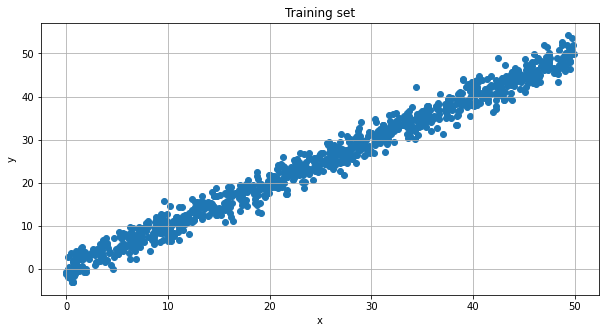

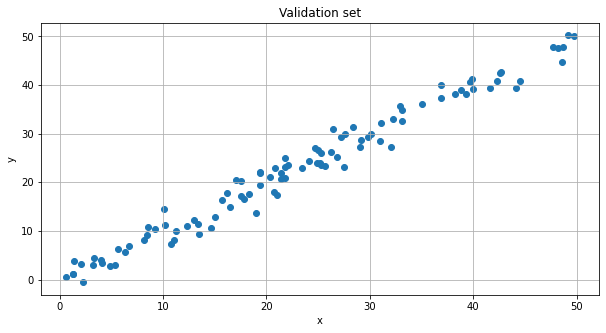

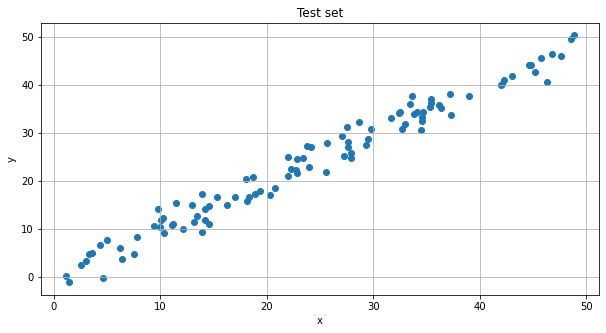

In [3]:
n_train = 1000
n_val = 100
n_test = 100

m = 1
b = 0
std = 2

x_train, y_train = generate_linear_regression_dataset(m, b, std, n_train, seed=1)
x_val, y_val = generate_linear_regression_dataset(m, b, std, n_val, seed=2)
x_test, y_test = generate_linear_regression_dataset(m, b, std, n_test, seed=3)

plt.figure(figsize=(10,5))
plt.scatter(x_train, y_train)
plt.title("Training set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid("on")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(x_val, y_val)
plt.title("Validation set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid("on")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(x_test, y_test)
plt.title("Test set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid("on")
plt.show()

Fit the model to the data. Two-layer neural network with MSE loss and linear activation in the last layer. The optimizer is SGD.

model summary: 
layer 0: dense: 
	 shape -- in: 1, out: 5
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 5, out: 1
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.447214^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: linear

mse with loss smoother constant
sgd with constant lr schedule and clipper who does nothing

starting epoch: 1 ...
batch 10/10: 100%|██████████| 10/10 [00:00<00:00, 573.88it/s]
epoch 1/10 
 	 -- train loss = 884.0759690225121 / train cost = 884.0759690225121
	 -- {"mse metrics_train": 884.0759690225121} 
	 -- val loss = 735.9596296588581 / val cost = 735.9596296588581
	 -- {"mse metrics_val": 735.9596296588581} 


starting epoch: 2 ...
batch 10/10: 100%|██████████| 10/10 [00:00<00:00, 386.17it/s]
epoch 2/10 
 	 -- train loss = 218.2429778014238 / train cost = 218.2429778014238
	 -- {"mse metrics_train"

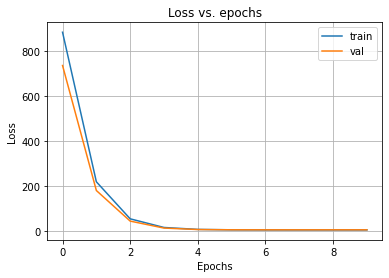

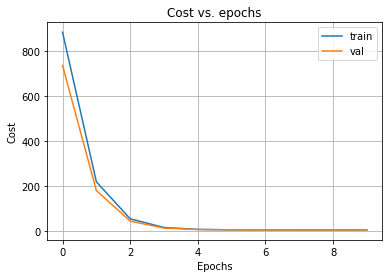

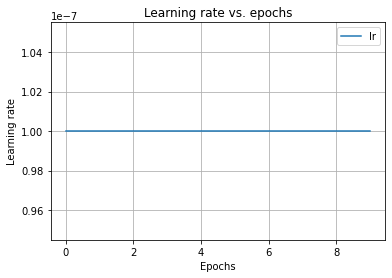

test metrics: {"mse metrics": 4.702617251033562}


In [4]:
coeff = 1.0
mean = 0.0
std = 0.001
params = {"coeff":coeff, "mean": mean, "std":None}

reg_rate_l2 = 0.01

in_dim = x_train.shape[1]
out_dim = 1
mid_dim = 5

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=None, 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=None, 
          activation=LinearActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)

loss = MeanSquaredErrorLoss(loss_smoother=LossSmootherConstant())

n_epochs = 10
batch_size = 100

# define the SGD optimizer with constant learning rate schedule (i.e: constant lr)
lr_initial = 1e-7
optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial), 
                         grad_clipper=GradClipperByNothing())

metrics = [MeanSquaredErrorMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func=None)

plot_losses(history)
plot_costs(history)
#plot_accuracies(history)
plot_lrs(history)

scores_test = model.forward(x_test)
#y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"test metrics: {json.dumps(metrics_test)}")

As shown in the figure below, the model learns the linear trend in the data. 

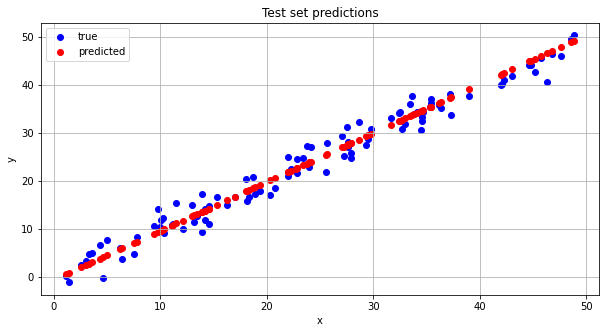

In [5]:
plt.figure(figsize=(10,5))
plt.scatter(x_test, y_test, c="b", label="true")
plt.scatter(x_test, scores_test, c="r", label="predicted")
plt.title("Test set predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid("on")
plt.savefig("assets/regression/linear.png")
plt.show()

## Non-Linear Regression <a class="anchor" id="non-linear"></a>

In this section, non-linear regression onto a single variable is presented. The training, validation, and test datasets are first drawn from the same distribution.

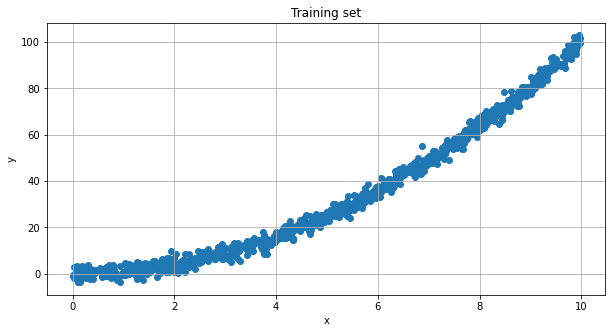

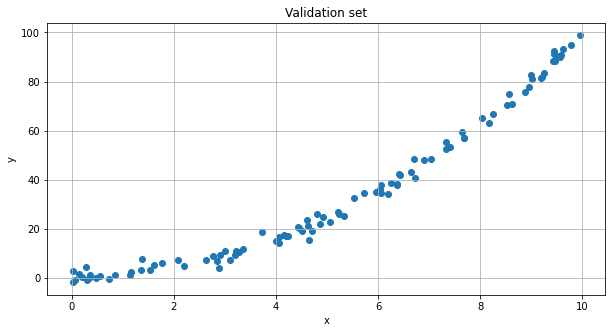

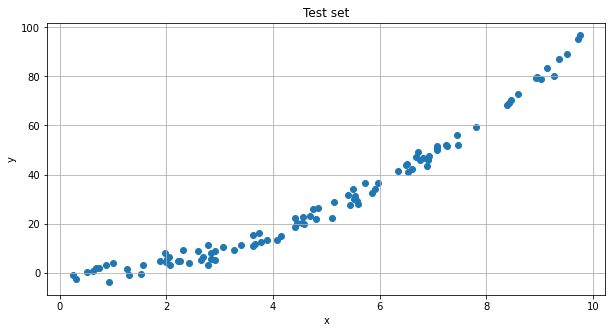

In [6]:
n_train = 1000
n_val = 100
n_test = 100

std = 2
b = 0

x_train, y_train = generate_non_linear_regression_dataset(b, std, n_train, seed=1)
x_val, y_val = generate_non_linear_regression_dataset(b, std, n_val, seed=12)
x_test, y_test = generate_non_linear_regression_dataset(b, std, n_test, seed=3)

plt.figure(figsize=(10,5))
plt.scatter(x_train, y_train)
plt.title("Training set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid("on")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(x_val, y_val)
plt.title("Validation set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid("on")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(x_test, y_test)
plt.title("Test set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid("on")
plt.show()

Fit the model to the data. Three-layer neural network with MSE loss and linear activation in the last layer. The optimizer is SGD.

model summary: 
layer 0: dense: 
	 shape -- in: 1, out: 100
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 100, out: 100
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.100000^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 2: dense: 
	 shape -- in: 100, out: 1
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.100000^2), reg: None
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: linear

mse with loss smoother constant
sgd with constant lr schedule and clipper who does nothing

starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 453.57it/s]
epoch 1/120 
 	 -- train loss = 128.1288716232006 / train cost = 128.1288716232006
	 -- {"mse metrics_train": 128.1288716232006} 
	 -- val loss = 136.19668191744503 / val cost = 136.19668191744503
	 -- {"mse metrics_val": 136.1966819

batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 467.61it/s]
epoch 24/120 
 	 -- train loss = 44.048575841317536 / train cost = 44.048575841317536
	 -- {"mse metrics_train": 44.048575841317536} 
	 -- val loss = 53.80918096819161 / val cost = 53.80918096819161
	 -- {"mse metrics_val": 53.80918096819161} 


starting epoch: 25 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 439.14it/s]
epoch 25/120 
 	 -- train loss = 41.9706086367076 / train cost = 41.9706086367076
	 -- {"mse metrics_train": 41.9706086367076} 
	 -- val loss = 51.58423371187344 / val cost = 51.58423371187344
	 -- {"mse metrics_val": 51.58423371187344} 


starting epoch: 26 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 424.18it/s]
epoch 26/120 
 	 -- train loss = 41.08444552512116 / train cost = 41.08444552512116
	 -- {"mse metrics_train": 41.08444552512116} 
	 -- val loss = 50.52821088910196 / val cost = 50.52821088910196
	 -- {"mse metrics_val": 50.52821088910196} 


starting epoch: 27 ...
batc

batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 535.52it/s]
epoch 49/120 
 	 -- train loss = 21.87452419017449 / train cost = 21.87452419017449
	 -- {"mse metrics_train": 21.87452419017449} 
	 -- val loss = 27.76768493458768 / val cost = 27.76768493458768
	 -- {"mse metrics_val": 27.76768493458768} 


starting epoch: 50 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 513.77it/s]
epoch 50/120 
 	 -- train loss = 21.389699290366558 / train cost = 21.389699290366558
	 -- {"mse metrics_train": 21.389699290366558} 
	 -- val loss = 27.156165346287597 / val cost = 27.156165346287597
	 -- {"mse metrics_val": 27.156165346287597} 


starting epoch: 51 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 530.40it/s]
epoch 51/120 
 	 -- train loss = 21.174747573787325 / train cost = 21.174747573787325
	 -- {"mse metrics_train": 21.174747573787325} 
	 -- val loss = 26.659199155033495 / val cost = 26.659199155033495
	 -- {"mse metrics_val": 26.659199155033495} 


starting epoch:

batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 467.18it/s]
epoch 74/120 
 	 -- train loss = 14.368616921726677 / train cost = 14.368616921726677
	 -- {"mse metrics_train": 14.368616921726677} 
	 -- val loss = 17.455642608083227 / val cost = 17.455642608083227
	 -- {"mse metrics_val": 17.455642608083227} 


starting epoch: 75 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 554.34it/s]
epoch 75/120 
 	 -- train loss = 13.175900823845229 / train cost = 13.175900823845229
	 -- {"mse metrics_train": 13.175900823845229} 
	 -- val loss = 16.291674504686977 / val cost = 16.291674504686977
	 -- {"mse metrics_val": 16.291674504686977} 


starting epoch: 76 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 517.12it/s]
epoch 76/120 
 	 -- train loss = 12.324593181407396 / train cost = 12.324593181407396
	 -- {"mse metrics_train": 12.324593181407396} 
	 -- val loss = 15.63627625096596 / val cost = 15.63627625096596
	 -- {"mse metrics_val": 15.63627625096596} 


starting epo

batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 378.07it/s]
epoch 99/120 
 	 -- train loss = 9.114888114207936 / train cost = 9.114888114207936
	 -- {"mse metrics_train": 9.114888114207936} 
	 -- val loss = 11.250470048995703 / val cost = 11.250470048995703
	 -- {"mse metrics_val": 11.250470048995703} 


starting epoch: 100 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 462.32it/s]
epoch 100/120 
 	 -- train loss = 8.93442917749623 / train cost = 8.93442917749623
	 -- {"mse metrics_train": 8.93442917749623} 
	 -- val loss = 11.075349636564177 / val cost = 11.075349636564177
	 -- {"mse metrics_val": 11.075349636564177} 


starting epoch: 101 ...
batch 100/100: 100%|██████████| 100/100 [00:00<00:00, 500.56it/s]
epoch 101/120 
 	 -- train loss = 8.92125991463252 / train cost = 8.92125991463252
	 -- {"mse metrics_train": 8.92125991463252} 
	 -- val loss = 11.39647327158442 / val cost = 11.39647327158442
	 -- {"mse metrics_val": 11.39647327158442} 


starting epoch: 102 ...

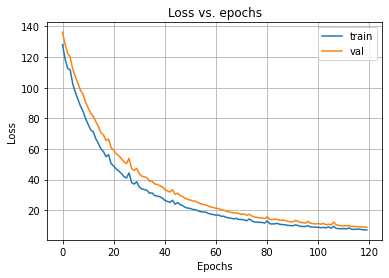

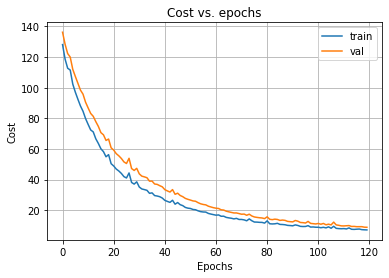

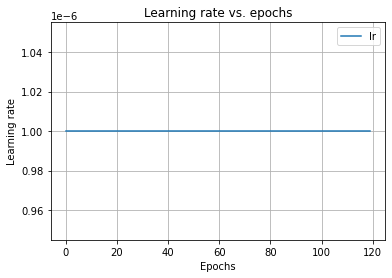

test metrics: {"mse metrics": 7.046357325838787}


In [7]:
coeff = 1.0
mean = 0.0
std = 0.001
params = {"coeff":coeff, "mean": mean, "std":None}

reg_rate_l2 = 0.01

in_dim = x_train.shape[1]
out_dim = 1
mid_dim = 100

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=None, 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=mid_dim,
          kernel_initializer=XavierInitializer(seed=seed+4, **params), 
          bias_initializer=XavierInitializer(seed=seed+5, **params), 
          kernel_regularizer=None, 
          activation=ReLUActivation()
         )

dense_3 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=None, 
          activation=LinearActivation()
         )

layers = [
    dense_1,
    dense_2,
    dense_3
]

model = Model(layers)

loss = MeanSquaredErrorLoss(loss_smoother=LossSmootherConstant())

n_epochs = 120
batch_size = 10

# define the SGD optimizer with constant learning rate schedule (i.e: constant lr)
lr_initial = 1e-6
optimizer = SGDOptimizer(lr_schedule=LRConstantSchedule(lr_initial), 
                         grad_clipper=GradClipperByNothing())

metrics = [MeanSquaredErrorMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func=None)

plot_losses(history)
plot_costs(history)
#plot_accuracies(history)
plot_lrs(history)

scores_test = model.forward(x_test)
#y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"test metrics: {json.dumps(metrics_test)}")

As shown in the figure below, the model learns the non-linear trend in the data.

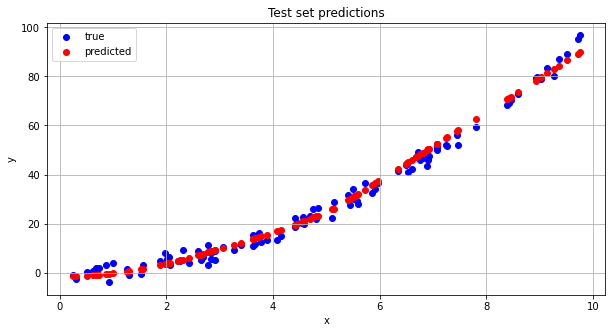

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(x_test, y_test, c="b", label="true")
plt.scatter(x_test, scores_test, c="r", label="predicted")
plt.title("Test set predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid("on")
plt.savefig("assets/regression/non_linear.png")
plt.show()